# Machine Learning for Complete Intersection Calabi-Yau Manifold

We use neural networks previously trained on the configuration matrix to perform **transfer learning** to the feature engineered dataset. We want to explore the possibility to improve the results even further by feeding the network additional information coming from engineered features.

## Infrastructure

We print information about the current OS:

In [1]:
from mltools.libos import InfoOS

print('Current OS:                  {} (kernel release: {}, architecture: {})'.format(InfoOS().os, InfoOS().kernel, InfoOS().arch))
print('Number of available threads: {:d}'.format(InfoOS().threads))
print('Current CPU frequency:       {:.0f} MHz (max: {:.0f} MHz)'.format(InfoOS().freq, InfoOS().freqm))
print('Available RAM memory:        {:d} MB (tot: {:d} MB)'.format(InfoOS().vmav, InfoOS().vmtot))

# print info on GPU
!nvidia-smi

Current OS:                  Linux (kernel release: 5.6.12-arch1-1, architecture: x86_64)
Number of available threads: 8
Current CPU frequency:       2300 MHz (max: 2800 MHz)
Available RAM memory:        7523 MB (tot: 15758 MB)
Sun May 17 09:47:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce 940MX       Off  | 00000000:02:00.0 Off |                  N/A |
| N/A   63C    P8    N/A /  N/A |      5MiB /  2004MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                    

## Setup

We import the Python modules we use and print their versions to keep track of changes.

In [2]:
import sys

import matplotlib as mpl
import random     as rnd
import sklearn    as skl
import numpy      as np
import pandas     as pd
import tensorflow as tf

from tensorflow       import keras
from tensorflow.keras import backend as K

import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # ignore user warnings: nothing that I can really do anything about it...


%matplotlib inline
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# print the version of the modules
print('Python version: {:d}.{:d}'      .format(sys.version_info.major, sys.version_info.minor))
print('Matplot version: {}'            .format(mpl.__version__))
print('Numpy version: {}'              .format(np.__version__))
print('Pandas version: {}'             .format(pd.__version__))
print('Scikit-learn version: {}'       .format(skl.__version__))
print('Tensorflow version: {}'         .format(tf.__version__))
print('Keras version: {} (backend: {})'.format(keras.__version__, K.backend()))

# fix random_seed
RAND = 42
rnd.seed(RAND)
np.random.seed(RAND)
tf.random.set_seed(RAND)

Python version: 3.7
Matplot version: 3.2.1
Numpy version: 1.18.4
Pandas version: 1.0.3
Scikit-learn version: 0.22.2.post1
Tensorflow version: 2.0.0
Keras version: 2.2.4-tf (backend: tensorflow)


## Session Preparation

in order to save the results of the analysis, we define where to store images, log files and models:

In [3]:
from os import path, makedirs

ROOT_DIR = '.' #-------------------------------------------------- root directory
IMG_DIR  = 'img' #------------------------------------------------ directory of images
MOD_DIR  = 'models' #--------------------------------------------- directory of saved models
LOG_DIR  = 'log' #------------------------------------------------ directory of logs
OUT_DIR  = 'output' #--------------------------------------------- directory for predictions, various outputs, etc.

DB_NAME = 'cicy3f' #---------------------------------------------- name of the dataset
DB_FILE = DB_NAME + '_analysis.h5' #------------------------------ full name with extension
DB_PATH = path.join(ROOT_DIR, DB_FILE) #-------------------------- full path of the dataset
DB_DIR  = 'original' if DB_NAME == 'cicy3o' else 'favourable' #--- subdir where to store images, models, logs

# define full paths
IMG_PATH = path.join(ROOT_DIR, IMG_DIR, DB_DIR)
MOD_PATH = path.join(ROOT_DIR, MOD_DIR, DB_DIR)
LOG_PATH = path.join(ROOT_DIR, LOG_DIR, DB_DIR)
OUT_PATH = path.join(ROOT_DIR, OUT_DIR, DB_DIR)

# create directories if non existent
if not path.isdir(IMG_PATH):
    makedirs(IMG_PATH, exist_ok=True)
if not path.isdir(MOD_PATH):
    makedirs(MOD_PATH, exist_ok=True)
if not path.isdir(LOG_PATH):
    makedirs(LOG_PATH, exist_ok=True)
if not path.isdir(OUT_PATH):
    makedirs(OUT_PATH, exist_ok=True)

We also create a log file to store debug and related information:

In [4]:
import logging

from mltools.liblog import create_logfile

path_to_log = path.join(LOG_PATH,
                        DB_NAME + '_nn_transfer_learning.log'
                       )
log = create_logfile(path_to_log,
                     name=DB_NAME + '_nn_transfer_learning',
                     level=logging.DEBUG
                    )

# these lines provide the same setup also for the Jupyter logging
logger = logging.getLogger() #------------------------------------------------- get the current logging session

fmt = logging.Formatter('%(asctime)s: %(levelname)s ==> %(message)s') #-------- customise the formatting options

handler = logging.StreamHandler() #-------------------------------------------- handle the stream to the default (stderr)
handler.setLevel(logging.DEBUG) #---------------------------------------------- print everything
handler.setFormatter(fmt) #---------------------------------------------------- set the formatting options

logger.handlers = [handler] #-------------------------------------------------- override the default stream

# we are ready to go!
log.info('New logging session started. Log is at {}.'.format(path_to_log))

2020-05-17 09:47:02,893: INFO ==> New logging session started. Log is at ./log/favourable/cicy3f_nn_transfer_learning.log.


We finally set the _memory growth_ property of the GPU in order to avoid overflowing its RAM memory:

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU') #--------------------------------------- list of physical GPUs

if gpus: #----------------------------------------------------------------------------------------- set memory growth only if GPU is active
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) #---------------------------------- set memory growth
            
        logical_gpus = tf.config.experimental.list_logical_devices('GPU') #------------------------ list of logical devices
        print('GPU setup: {:d} physical GPUs, {:d} logical GPUs.'.format(len(gpus),
                                                                         len(logical_gpus)
                                                                        )
             )
    except RuntimeError as e:
        print(e)
else:
    print('No GPUs in the setup!')

GPU setup: 1 physical GPUs, 1 logical GPUs.


## Loading the Dataset

We first load the dataset we built during the preanalysis.

In [6]:
import pandas as pd

# load the dataset
if path.isfile(DB_PATH):
    df = pd.read_hdf(DB_PATH)
    log.debug('Database loaded.')
    log.info('Shape is {:d} rows x {:d} columns.'.format(df.shape[0], df.shape[1]))
else:
    log.error('Cannot load database from {}!'.format(DB_PATH))

2020-05-17 09:47:03,423: DEBUG ==> Database loaded.
2020-05-17 09:47:03,424: INFO ==> Shape is 7852 rows x 7 columns.


## Dense Format Extraction

We now extract the matrix from the available features and the labels. Notice that in this case we do not flatten the output as it will be processed by _Conv2D_ layers in _Keras_: we reshape it as if it was a black and white image, that is we take each matrix of shape (width, height) and output a matrix of shape (width, height, 1):

In [7]:
from mltools.libtransformer import ExtractTensor

# extract the labels
h11    = df['h11'].values
h21    = df['h21'].values

# we extract scalar and vector features
num_cp     = np.array(ExtractTensor(flatten=True).fit_transform(df['num_cp'])).reshape(-1,1)
dim_cp     = np.array(ExtractTensor(flatten=True).fit_transform(df['dim_cp']))
dim_h0_amb = np.array(ExtractTensor(flatten=True).fit_transform(df['dim_h0_amb']))

# extract the tensor features
matrix = np.array(ExtractTensor(flatten=False).fit_transform(df['matrix'])) #-------- old shape is (batch, width, height)
matrix = np.reshape(matrix, (-1, np.shape(matrix)[1], np.shape(matrix)[2], 1)) #----- new shape is (batch, width, height, 1)

log.debug('Matrix shape: {}'.format(np.shape(matrix)))

2020-05-17 09:47:05,622: DEBUG ==> Matrix shape: (7852, 15, 18, 1)


## Training and Validation Strategy

We now define the validation strategy and split the dataset into training, validation and test sets.

We will take out 10% of the dataset to be our **test set**. For the remaining 90% of the dataset, we will use **holdout validation** with $\frac{1}{9}$ of the training samples as validation (effectively we use 80% of the total set for training and 10% as validation).

In [8]:
from sklearn.model_selection import train_test_split

# divide into training and test sets
num_cp_train, num_cp_test, \
dim_cp_train, dim_cp_test, \
dim_h0_amb_train, dim_h0_amb_test, \
matrix_train, matrix_test, \
num_cp_train, num_cp_test, \
h11_train, h11_test, \
h21_train, h21_test = train_test_split(num_cp, dim_cp, dim_h0_amb, matrix, num_cp, h11, h21, test_size=0.1, shuffle=False)

# keep a holdout validation set
num_cp_train, num_cp_val, \
dim_cp_train, dim_cp_val, \
dim_h0_amb_train, dim_h0_amb_val, \
matrix_train, matrix_val, \
num_cp_train, num_cp_val, \
h11_train, h11_val, \
h21_train, h21_val = train_test_split(num_cp_train, dim_cp_train, dim_h0_amb_train, matrix_train, num_cp_train, h11_train, h21_train, test_size=1.0/9.0, shuffle=False)

log.debug('Train set size: {:d}'.format(np.shape(matrix_train)[0]))
log.debug('Validation set size: {:d}'.format(np.shape(matrix_val)[0]))
log.debug('Test set size: {:d}'.format(np.shape(matrix_test)[0]))

2020-05-17 09:47:05,655: DEBUG ==> Train set size: 6280
2020-05-17 09:47:05,656: DEBUG ==> Validation set size: 786
2020-05-17 09:47:05,658: DEBUG ==> Test set size: 786


We also provide a way to visualise the predictions by comparing the predictions as function of a (scalar) base feature (e.g.: `num_cp`) with respect to the ground truth:

In [9]:
def get_counts(base_feature, label):
    '''
    Returns unique values and counts of the label as a function of the base_feature.
    
    Required arguments:
        base_feature: the feature considered as base for the comparison,
        label:        the label we are interested in comparing.
    
    Yields:
        [ unique value of base_feature, unique value of label, count ].
    '''
    
    for n in np.sort(np.unique(base_feature)):
        uniques, counts = np.unique(label[np.argwhere(base_feature == n)[:,0]], return_counts=True)
        
        for u, c in np.c_[uniques, counts]:
            yield [n, u, c]

Notice that the use of `num_cp` will only be necessary to show in a simple way how well the algorithm can predict $h_{11}$ and $h_{21}$. `num_cp` will be taken as a representative of the matrices in the test set and $h_{11}$ and $h_{21}$ will be shown in a 2D plot.

## Feature Rescaling

Before proceeding we rescale the input matrices to have entries in $\left[ 0, 1 \right]$: we divide each entry of each matrix by the range of variation of its entries (since they are all positive, we divide by the maximum) in the **training** set. We then apply the **same scaling** to validation and test sets.

In [10]:
from sklearn.preprocessing import StandardScaler

# compute the scale factor
scale_factor = np.max(matrix_train) - np.min(matrix_train)

# rescale the sets
matrix_train = matrix_train / scale_factor
matrix_val   = matrix_val   / scale_factor
matrix_test  = matrix_test  / scale_factor

# define the shape of the tensors (batch axis excluded) since we will use it later one
input_shape  = np.shape(matrix_train)[1:]

# then apply the usual rescaling to the other features
num_cp_scaler     = StandardScaler()
dim_cp_scaler     = StandardScaler()
dim_h0_amb_scaler = StandardScaler()

num_cp_train     = num_cp_scaler.fit_transform(num_cp_train)
num_cp_val       = num_cp_scaler.transform(num_cp_val)
num_cp_test      = num_cp_scaler.transform(num_cp_test)
dim_cp_train     = dim_cp_scaler.fit_transform(dim_cp_train)
dim_cp_val       = dim_cp_scaler.transform(dim_cp_val)
dim_cp_test      = dim_cp_scaler.transform(dim_cp_test)
dim_h0_amb_train = dim_h0_amb_scaler.fit_transform(dim_h0_amb_train)
dim_h0_amb_val   = dim_h0_amb_scaler.transform(dim_h0_amb_val)
dim_h0_amb_test  = dim_h0_amb_scaler.transform(dim_h0_amb_test)

## Model Building

We the build the architecture of the CNN. In this section we use **transfer learning** from the networks previously trained on the configuration matrix to predict $h_{11}$ and $h_{21}$. We then add other inputs to the matrices in order to improve the predictions.

In [11]:
from tensorflow.keras              import Input
from tensorflow.keras.utils        import model_to_dot
from tensorflow.keras.models       import Model, load_model
from tensorflow.keras.layers       import Conv1D, Conv2D, Dense, Lambda, Flatten, BatchNormalization, Dropout, LeakyReLU, concatenate, Activation
from tensorflow.keras.optimizers   import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks    import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def cnn_full_model(model_name,
                   h11_model_path,
                   h21_model_path,
                   num_cp_shape,
                   dim_cp_shape,
                   dim_h0_amb_shape,
                   num_cp_neurons_h11=[30],
                   num_cp_neurons_h21=[30],
                   dim_cp_neurons_h11=[30],
                   dim_cp_neurons_h21=[30],
                   dim_h0_amb_neurons_h11=[30],
                   dim_h0_amb_neurons_h21=[30],
                   learning_rate=0.01,
                   batch_norm_momentum=0.99,
                   dropout_rate=0.3,
                   leaky_alpha=0.3,
                   l1_reg=0.0,
                   l2_reg=0.0,
                   last_relu=False,
                   last_layer_h11=1,
                   last_layer_h21=1
                  ):
    '''
    Build a convolutional neural network with given parameters.
    
    Required arguments:
        model_name:             the name of the model
        h11_model_path:         the path of the CNN model to predict h11
        h21_model_path:         the path of the CNN model to predict h21
        num_cp_shape:           the shape of the tensor for num_cp
        dim_cp_shape:           the shape of the tensor for dim_cp
        dim_h0_amb_shape:       the shape of the tensor for dim_h0_amb
        
    Optional arguments:
        learning_rate:          the learning rate of SGD (Adam optimizer)
        num_cp_neurons_h11:     the list of units in each layer of the network for num_cp (for h11)
        num_cp_neurons_h21:     the list of units in each layer of the network for num_cp (for h21)
        dim_cp_neurons_h11:     the list of units in each layer of the network for dim_cp (for h11)
        dim_cp_neurons_h21:     the list of units in each layer of the network for dim_cp (for h21)
        dim_h0_amb_neurons_h11: the list of units in each layer of the network for dim_h0_amb (for h11)
        dim_h0_amb_neurons_h21: the list of units in each layer of the network for dim_h0_amb (for h21)
        batch_norm_momentum:    the momentum of the batch normalization
        dropout_rate:           the rate of the dropout in percentage
        leaky_alpha:            the slope of the LeakyReLU activation function
        l1_reg:                 the l1 regularization
        l2_reg:                 the l2 regularization
        last_relu:              whether to add ReLU activation function on the output layer
        last_layer_h11:         the no. of layers to insert between the concatenation of layers and the output node for h11
        last_layer_h21:         the no. of layers to insert between the concatenation of layers and the output node for h22
        
    Returns:
        the compiled model
    '''
    # regularization
    regularization = l1_l2(l1=l1_reg, l2=l2_reg)
    
    # import the pretrained models
    if path.isfile(h11_model_path):
        h11_model = load_model(h11_model_path)

    if path.isfile(h21_model_path):
        h21_model = load_model(h21_model_path)
        
    # freeze the layers in the pre-trained models
    h11_model.trainable = False
    h21_model.trainable = False
    
    for n in range(len(h11_model.layers)):
        h11_model.layers[n].trainable = False
    for n in range(len(h21_model.layers)):
        h21_model.layers[n].trainable = False
        
    # then build the network for num_cp
    num_cp_in  = Input(shape=num_cp_shape, name='num_cp_input')
    num_cp_h11 = Lambda(lambda z: z, name='lambda_num_cp_h11')(num_cp_in)
    num_cp_h21 = Lambda(lambda z: z, name='lambda_num_cp_h21')(num_cp_in)
    
    for n_layer in range(len(num_cp_neurons_h11)):
        num_cp_h11 = Dense(units=num_cp_neurons_h11[n_layer],
                           kernel_regularizer=regularization,
                           name='num_cp_h11_{:d}'.format(n_layer)
                          )(num_cp_h11)
        num_cp_h11 = LeakyReLU(alpha=leaky_alpha,
                               name='num_cp_h11_activation_{:d}'.format(n_layer)
                              )(num_cp_h11)
        
        if batch_norm_momentum > 0.0:
            num_cp_h11 = BatchNormalization(momentum=batch_norm_momentum,
                                            name='num_cp_h11_batch_norm_{:d}'.format(n_layer)
                                           )(num_cp_h11)
    
    for n_layer in range(len(num_cp_neurons_h21)):
        num_cp_h21 = Dense(units=num_cp_neurons_h21[n_layer],
                           kernel_regularizer=regularization,
                           name='num_cp_h21_{:d}'.format(n_layer)
                          )(num_cp_h21)
        num_cp_h21 = LeakyReLU(alpha=leaky_alpha,
                               name='num_cp_h21_activation_{:d}'.format(n_layer)
                              )(num_cp_h21)
        
        if batch_norm_momentum > 0.0:
            num_cp_h21 = BatchNormalization(momentum=batch_norm_momentum,
                                            name='num_cp_h21_batch_norm_{:d}'.format(n_layer)
                                           )(num_cp_h21)
    
    if dropout_rate > 0.0:
        num_cp_h11 = Dropout(rate=dropout_rate, name='num_cp_h11_dropout')(num_cp_h11)
        num_cp_h21 = Dropout(rate=dropout_rate, name='num_cp_h21_dropout')(num_cp_h21)
        
    # then build the network for dim_cp
    dim_cp_in  = Input(shape=dim_cp_shape, name='dim_cp_input')
    dim_cp_h11 = Lambda(lambda z: z, name='lambda_dim_cp_h11')(dim_cp_in)
    dim_cp_h21 = Lambda(lambda z: z, name='lambda_dim_cp_h21')(dim_cp_in)
    
    for n_layer in range(len(dim_cp_neurons_h11)):
        dim_cp_h11 = Dense(units=dim_cp_neurons_h11[n_layer],
                           kernel_regularizer=regularization,
                           name='dim_cp_h11_{:d}'.format(n_layer)
                          )(dim_cp_h11)
        dim_cp_h11 = LeakyReLU(alpha=leaky_alpha,
                               name='dim_cp_h11_activation_{:d}'.format(n_layer)
                              )(dim_cp_h11)
        
        if batch_norm_momentum > 0.0:
            dim_cp_h11 = BatchNormalization(momentum=batch_norm_momentum,
                                            name='dim_cp_h11_batch_norm_{:d}'.format(n_layer)
                                           )(dim_cp_h11)
    
    for n_layer in range(len(dim_cp_neurons_h21)):
        dim_cp_h21 = Dense(units=dim_cp_neurons_h21[n_layer],
                           kernel_regularizer=regularization,
                           name='dim_cp_h21_{:d}'.format(n_layer)
                          )(dim_cp_h21)
        dim_cp_h21 = LeakyReLU(alpha=leaky_alpha,
                               name='dim_cp_h21_activation_{:d}'.format(n_layer)
                              )(dim_cp_h21)
        
        if batch_norm_momentum > 0.0:
            dim_cp_h21 = BatchNormalization(momentum=batch_norm_momentum,
                                            name='dim_cp_h21_batch_norm_{:d}'.format(n_layer)
                                           )(dim_cp_h21)
    
    if dropout_rate > 0.0:
        dim_cp_h11 = Dropout(rate=dropout_rate, name='dim_cp_h11_dropout')(dim_cp_h11)
        dim_cp_h21 = Dropout(rate=dropout_rate, name='dim_cp_h21_dropout')(dim_cp_h21)
        
    # then build the network for dim_h0_amb
    dim_h0_amb_in  = Input(shape=dim_h0_amb_shape, name='dim_h0_amb_input')
    dim_h0_amb_h11 = Lambda(lambda z: z, name='lambda_dim_h0_amb_h11')(dim_h0_amb_in)
    dim_h0_amb_h21 = Lambda(lambda z: z, name='lambda_dim_h0_amb_h21')(dim_h0_amb_in)
    
    for n_layer in range(len(dim_h0_amb_neurons_h11)):
        dim_h0_amb_h11 = Dense(units=dim_h0_amb_neurons_h11[n_layer],
                           kernel_regularizer=regularization,
                           name='dim_h0_amb_h11_{:d}'.format(n_layer)
                          )(dim_h0_amb_h11)
        dim_h0_amb_h11 = LeakyReLU(alpha=leaky_alpha,
                               name='dim_h0_amb_h11_activation_{:d}'.format(n_layer)
                              )(dim_h0_amb_h11)
        
        if batch_norm_momentum > 0.0:
            dim_h0_amb_h11 = BatchNormalization(momentum=batch_norm_momentum,
                                            name='dim_h0_amb_h11_batch_norm_{:d}'.format(n_layer)
                                           )(dim_h0_amb_h11)
    
    for n_layer in range(len(dim_h0_amb_neurons_h21)):
        dim_h0_amb_h21 = Dense(units=dim_h0_amb_neurons_h21[n_layer],
                           kernel_regularizer=regularization,
                           name='dim_h0_amb_h21_{:d}'.format(n_layer)
                          )(dim_h0_amb_h21)
        dim_h0_amb_h21 = LeakyReLU(alpha=leaky_alpha,
                               name='dim_h0_amb_h21_activation_{:d}'.format(n_layer)
                              )(dim_h0_amb_h21)
        
        if batch_norm_momentum > 0.0:
            dim_h0_amb_h21 = BatchNormalization(momentum=batch_norm_momentum,
                                            name='dim_h0_amb_h21_batch_norm_{:d}'.format(n_layer)
                                           )(dim_h0_amb_h21)
    
    if dropout_rate > 0.0:
        dim_h0_amb_h11 = Dropout(rate=dropout_rate, name='dim_h0_amb_h11_dropout')(dim_h0_amb_h11)
        dim_h0_amb_h21 = Dropout(rate=dropout_rate, name='dim_h0_amb_h21_dropout')(dim_h0_amb_h21)
      
    # concatenate the outputs
    h11_transfer_learning = concatenate([h11_model.output,
                                         num_cp_h11,
                                         dim_cp_h11,
                                         dim_h0_amb_h11],
                                        name='h11_concatenate'
                                       )
    for n in range(last_layer_h11):
        h11_transfer_learning = Dense(units=h11_transfer_learning.shape[1],
                                      name='h11_concatenate_dense_{:d}'.format(n)
                                     )(h11_transfer_learning)
        h11_transfer_learning = LeakyReLU(alpha=leaky_alpha,
                                          name='h11_concatenate_dense_activation_{:d}'.format(n)
                                         )(h11_transfer_learning)
    
    # improve the result of the matrix with the processed output
    h11_transfer_learning = Dense(units=1, name='h11_improvements')(h11_transfer_learning)
    h11_transfer_learning = LeakyReLU(alpha=leaky_alpha, name='h11_improvements_activation')(h11_transfer_learning)
    h11_transfer_learning = concatenate([h11_transfer_learning, h11_model.output])
    h11_transfer_learning = Dense(units=1,
                                  activation='relu',
                                  name='h11'
                                 )(h11_transfer_learning) if last_relu \
                                                          else Dense(units=1,
                                                                     name='h11'
                                                                    )(h11_transfer_learning)
    
    h21_transfer_learning = concatenate([h21_model.output,
                                         h11_model.output,
                                         num_cp_h21,
                                         dim_cp_h21,
                                         dim_h0_amb_h21],
                                        name='h21_concatenate'
                                       )
    for n in range(last_layer_h21):
        h21_transfer_learning = Dense(units=h21_transfer_learning.shape[1],
                                      name='h21_concatenate_dense_{:d}'.format(n)
                                     )(h21_transfer_learning)
        h21_transfer_learning = LeakyReLU(alpha=leaky_alpha,
                                          name='h21_concatenate_dense_activation_{:d}'.format(n)
                                         )(h21_transfer_learning)
        
    # improve the result of the matrix with the processed output
    h21_transfer_learning = Dense(units=1, activation='relu', name='h21_improvements')(h21_transfer_learning)
    h21_transfer_learning = LeakyReLU(alpha=leaky_alpha, name='h21_improvements_activation')(h21_transfer_learning)
    h21_transfer_learning = concatenate([h21_transfer_learning, h21_model.output])
    h21_transfer_learning = Dense(units=1,
                                  activation='relu',
                                  name='h21'
                                 )(h21_transfer_learning) if last_relu \
                                                          else Dense(units=1,
                                                                     name='h21'
                                                                    )(h21_transfer_learning)
    # compile the model
    model = Model(inputs=[h11_model.input, h21_model.input, num_cp_in, dim_cp_in, dim_h0_amb_in],
                  outputs=[h11_transfer_learning, h21_transfer_learning],
                  name=model_name
                 )
    model.compile(optimizers=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return model

We then visualise the model:

2020-05-17 09:47:05,908: DEBUG ==> Building the full convolutional model...


Model: "full_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
h11_inception_same_conv_no_fc_i [(None, 15, 18, 1)]  0                                            
__________________________________________________________________________________________________
h21_inception_same_conv_no_fc_i [(None, 15, 18, 1)]  0                                            
__________________________________________________________________________________________________
h11_inception_same_conv_no_fc_c (None, 15, 18, 32)   512         h11_inception_same_conv_no_fc_inp
__________________________________________________________________________________________________
h11_inception_same_conv_no_fc_c (None, 15, 18, 32)   608         h11_inception_same_conv_no_fc_inp
_________________________________________________________________________________________

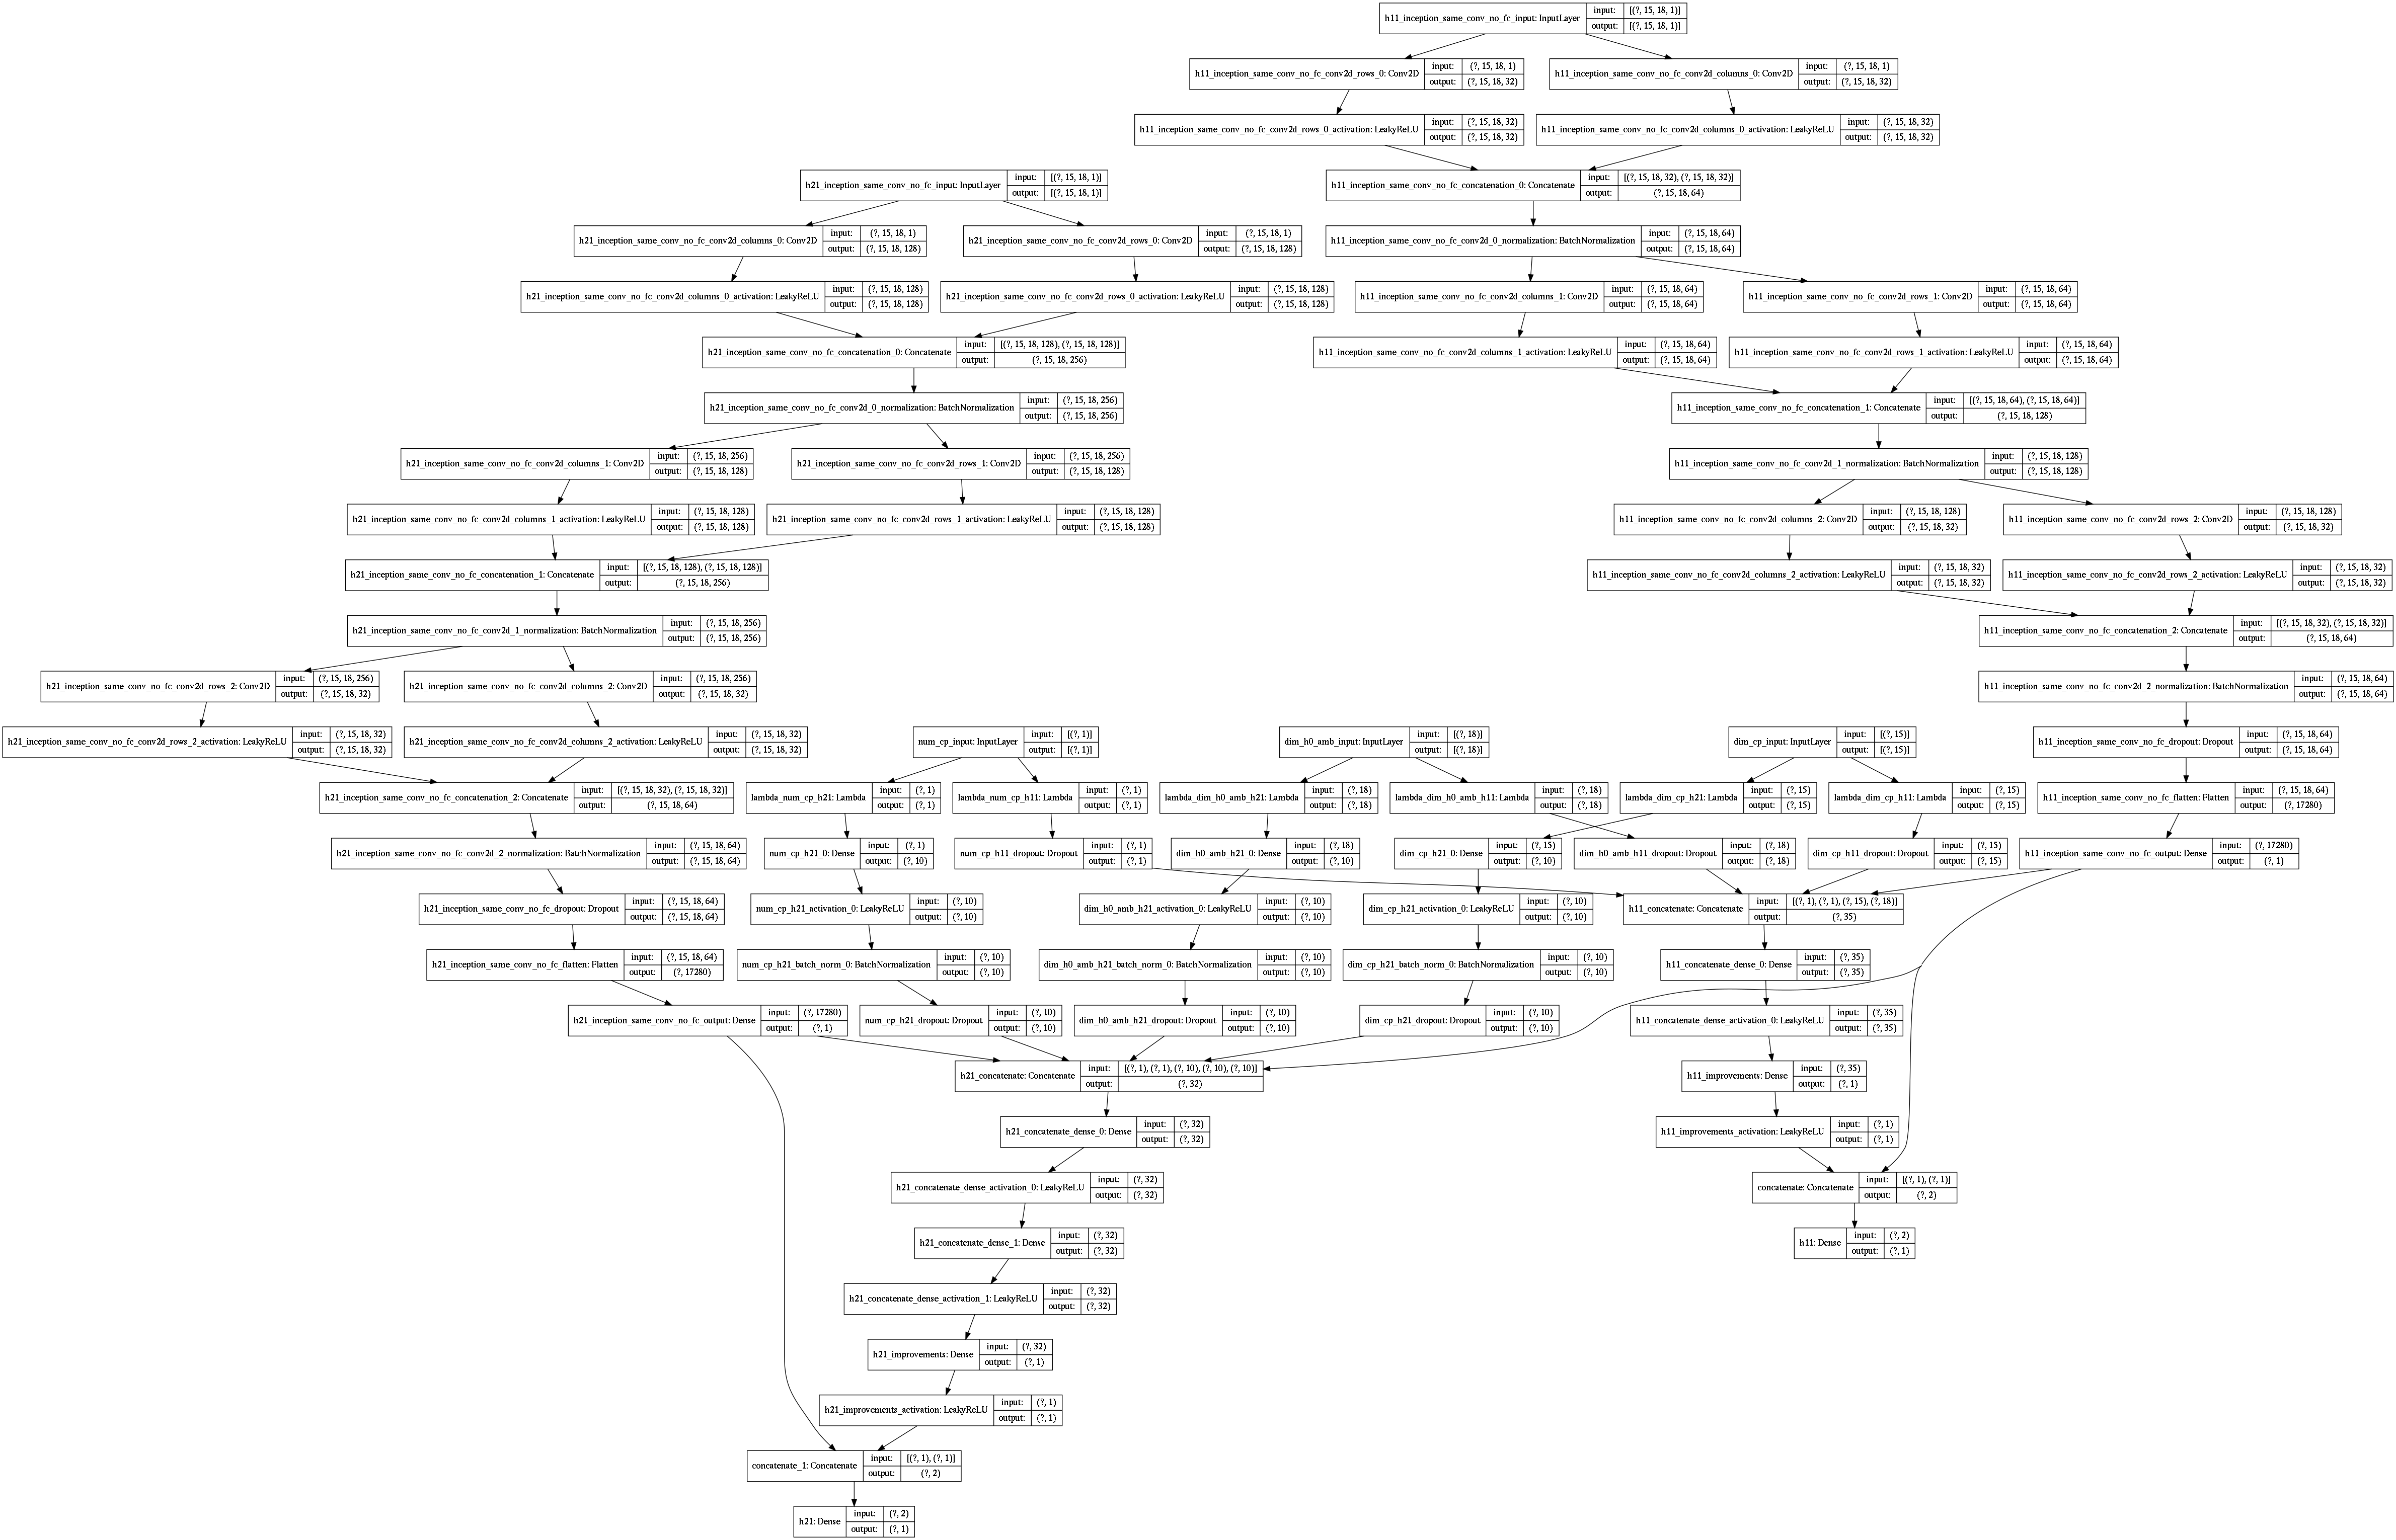

In [12]:
from IPython.display import Image

h11_model_path = path.join(MOD_PATH, 'h11_inception_same_conv_no_fc.h5')
h21_model_path = path.join(MOD_PATH, 'h21_inception_same_conv_no_fc.h5')

log.debug('Building the full convolutional model...')
K.clear_session() #--------------------------------------------------- clear the Tensorflow session
model = cnn_full_model(model_name='full_model',
                       h11_model_path=h11_model_path,
                       h21_model_path=h21_model_path,
                       num_cp_shape=num_cp_train.shape[1:],
                       dim_cp_shape=dim_cp_train.shape[1:],
                       dim_h0_amb_shape=dim_h0_amb_train.shape[1:],
                       num_cp_neurons_h11=[],
                       num_cp_neurons_h21=[10],
                       dim_cp_neurons_h11=[],
                       dim_cp_neurons_h21=[10],
                       dim_h0_amb_neurons_h11=[],
                       dim_h0_amb_neurons_h21=[10],
                       learning_rate=0.03,
                       batch_norm_momentum=0.99,
                       dropout_rate=0.3,
                       leaky_alpha=0.0,
                       l1_reg=1.0e-5,
                       l2_reg=1.0e-4,
                       last_relu=True,
                       last_layer_h11=1,
                       last_layer_h21=2
                      )

model.summary()
model_dot = model_to_dot(model=model, show_shapes=True, show_layer_names=True)
model_dot.write_pdf(path.join(IMG_PATH, model.name + '.pdf'))

Image(model_dot.create_png())

And finally we fit the model. We have two options: the first is to monitor the **validation loss** to measure the stability of the algorithm and choose the best training epoch and the second is to separately monitor the **MSE** on $h_{11}$ and $h_{21}$ and separately produce predictions for the Hodge numbers. After many trials with the first option, we decide to use the second method (even though it takes longer) because we want to get the best possible predictions in a consistent way.

In [13]:
# define the callbacks (NB: with restore_best_weights we do not need to reload the model for evaluation)
callbacks_h11=[EarlyStopping(monitor='val_h11_mean_squared_error', patience=400, verbose=0, restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_h11_mean_squared_error', factor=0.33, patience=150, verbose=0),
               ModelCheckpoint(monitor='val_h11_mean_squared_error', filepath=path.join(MOD_PATH, 'h11_transfer_learning.h5'), verbose=0, save_best_only=True)
              ]

# fit the model
log.info('Training the full model with the h11 objectives...')
model_hst_h11 = model.fit(x=[matrix_train, matrix_train, num_cp_train, dim_cp_train, dim_h0_amb_train],
                          y=[h11_train, h21_train],
                          batch_size=128,
                          epochs=5000,
                          verbose=0,
                          callbacks=callbacks_h11,
                          validation_data=([matrix_val, matrix_val, num_cp_val, dim_cp_val, dim_h0_amb_val], [h11_val, h21_val])
                         )

2020-05-17 09:47:14,338: INFO ==> Training the full model with the h11 objectives...


We then evaluate the model with the $h_{11}$ objectives:

Accuracy of full_model on the validation set: 98.728%
Accuracy of full_model on the test set: 98.855%


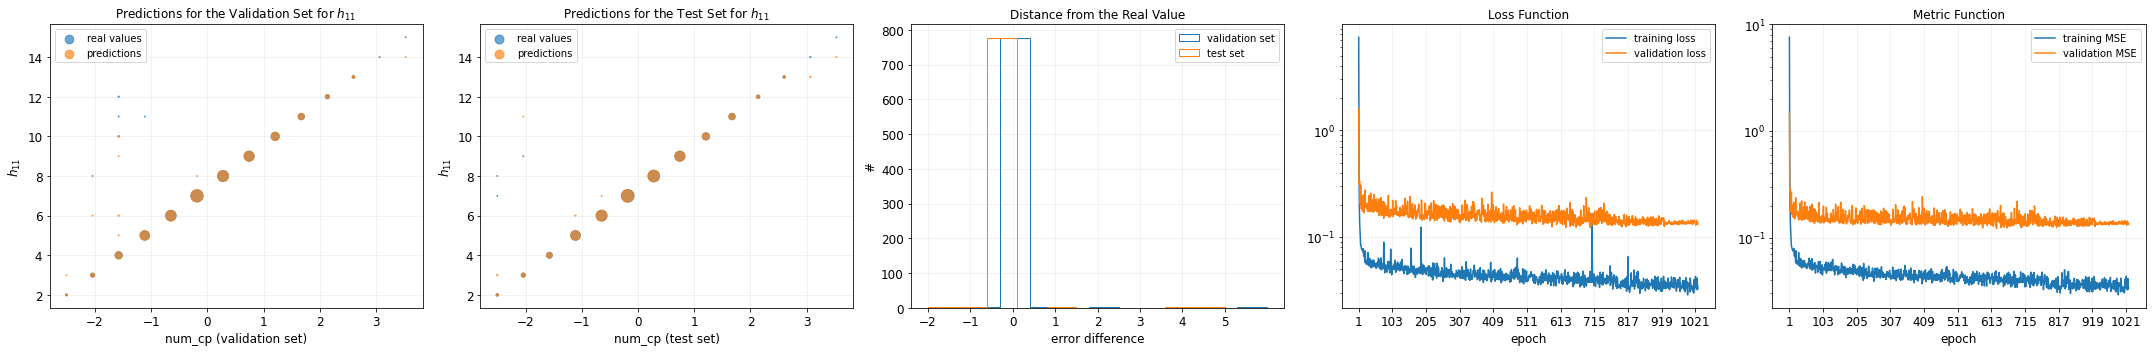

2020-05-17 13:27:01,524: DEBUG ==> Plot saved to ./img/favourable/full_model_h11.pdf.


In [14]:
from mltools.libplot  import Plot
from mltools.libscore import Score

# compute the predictions
model_val_predictions  = model.predict([matrix_val, matrix_val, num_cp_val, dim_cp_val, dim_h0_amb_val])[0].reshape(-1,) #------- take only h11 predictions
model_test_predictions = model.predict([matrix_test, matrix_test, num_cp_test, dim_cp_test, dim_h0_amb_test])[0].reshape(-1,)

# compute the accuracy and score of the predictions
rounding = np.rint
model_score_val  = Score(y_true=h11_val, y_pred=model_val_predictions, rounding=rounding)
model_score_test = Score(y_true=h11_test, y_pred=model_test_predictions, rounding=rounding)
print('Accuracy of {} on the validation set: {:.3f}%'.format(model.name, model_score_val.accuracy()*100))
print('Accuracy of {} on the test set: {:.3f}%'.format(model.name, model_score_test.accuracy()*100))

# plot the distribution of the predictions and the error difference
plot = Plot(rows=1, columns=5)

plot.scatter2D(np.array(list(get_counts(num_cp_val, h11_val))).T,
               axis=0,
               title='Predictions for the Validation Set for $h_{11}$',
               legend='real values',
               xlabel='num_cp (validation set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_val, rounding(model_val_predictions)))).T,
               axis=0,
               title='Predictions for the Validation Set for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (validation set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h11_test))).T,
               axis=1,
               title='Predictions for the Test Set for $h_{11}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(model_test_predictions)))).T,
               axis=1,
               title='Predictions for the Test Set for $h_{11}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{11}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(model_score_val.error(),
            axis=2,
            title='Distance from the Real Value',
            legend='validation set',
            xlabel='error difference',
            ylabel='#',
            binstep=1
           )
plot.hist2D(model_score_test.error(),
            axis=2,
            title='Distance from the Real Value',
            legend='test set',
            xlabel='error difference',
            ylabel='#',
            binstep=1
           )

plot.series2D(data=model_hst_h11.history['h11_loss'],
              axis=3,
              title='Loss Function',
              xlabel='epoch',
              legend='training loss',
              ylog=True,
              binstep=int(np.shape(model_hst_h11.history['h11_loss'])[0] / 10)
             )
plot.series2D(data=model_hst_h11.history['val_h11_loss'],
              axis=3,
              title='Loss Function',
              xlabel='epoch',
              legend='validation loss',
              ylog=True,
              binstep=int(np.shape(model_hst_h11.history['val_h11_loss'])[0] / 10)
             )

plot.series2D(data=model_hst_h11.history['h11_mean_squared_error'],
              axis=4,
              title='Metric Function',
              xlabel='epoch',
              legend='training MSE',
              ylog=True,
              binstep=int(np.shape(model_hst_h11.history['h11_mean_squared_error'])[0] / 10)
             )
plot.series2D(data=model_hst_h11.history['val_h11_mean_squared_error'],
              axis=4,
              title='Metric Function',
              xlabel='epoch',
              legend='validation MSE',
              ylog=True,
              binstep=int(np.shape(model_hst_h11.history['val_h11_mean_squared_error'])[0] / 10)
             )

plot.save_and_close(path.join(IMG_PATH, model.name + '_h11'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, model.name + '_h11.pdf')))

We then keep training to find the best $h_{21}$ result:

In [15]:
# define the callbacks (NB: with restore_best_weights we do not need to reload the model for evaluation)
callbacks_h21=[EarlyStopping(monitor='val_h21_mean_squared_error', patience=400, verbose=0, restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_h21_mean_squared_error', factor=0.33, patience=150, verbose=0),
               ModelCheckpoint(monitor='val_h21_mean_squared_error', filepath=path.join(MOD_PATH, 'h21_transfer_learning.h5'), verbose=0, save_best_only=True)
              ]

# fit the model
log.debug('Training the full model with the h21 objectives...')
model_hst_h21 = model.fit(x=[matrix_train, matrix_train, num_cp_train, dim_cp_train, dim_h0_amb_train],
                          y=[h11_train, h21_train],
                          batch_size=256,
                          epochs=5000,
                          verbose=0,
                          callbacks=callbacks_h21,
                          validation_data=([matrix_val, matrix_val, num_cp_val, dim_cp_val, dim_h0_amb_val], [h11_val, h21_val])
                         )

2020-05-17 13:27:01,543: DEBUG ==> Training the full model with the h21 objectives...


We then evaluate the model with the $h_{21}$ objectives:

Accuracy of full_model on the validation set: 46.947%
Accuracy of full_model on the test set: 48.473%


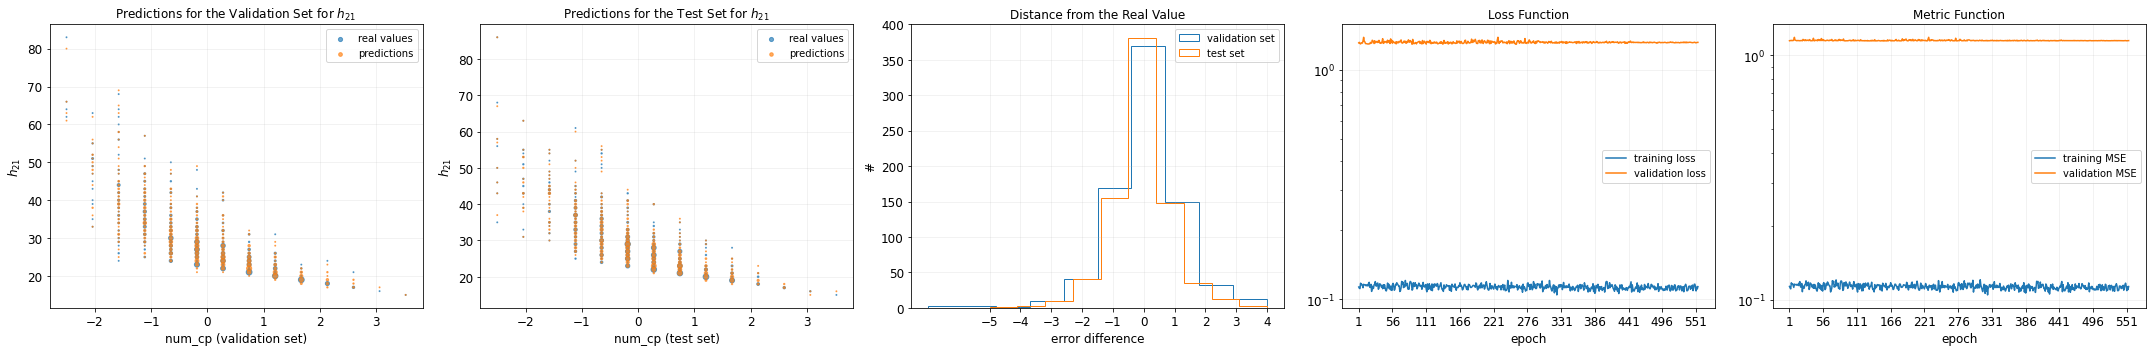

2020-05-17 15:20:31,972: DEBUG ==> Plot saved to ./img/favourable/full_model_h21.pdf.


In [16]:
from mltools.libplot  import Plot
from mltools.libscore import Score

# compute the predictions
model_val_predictions  = model.predict([matrix_val, matrix_val, num_cp_val, dim_cp_val, dim_h0_amb_val])[1].reshape(-1,) #---------- take only h21 predictions
model_test_predictions = model.predict([matrix_test, matrix_test, num_cp_test, dim_cp_test, dim_h0_amb_test])[1].reshape(-1,)

# compute the accuracy and score of the predictions
rounding = np.rint
model_score_val  = Score(y_true=h21_val, y_pred=model_val_predictions, rounding=rounding)
model_score_test = Score(y_true=h21_test, y_pred=model_test_predictions, rounding=rounding)
print('Accuracy of {} on the validation set: {:.3f}%'.format(model.name, model_score_val.accuracy()*100))
print('Accuracy of {} on the test set: {:.3f}%'.format(model.name, model_score_test.accuracy()*100))

# plot the distribution of the predictions and the error difference
plot = Plot(rows=1, columns=5)

plot.scatter2D(np.array(list(get_counts(num_cp_val, h21_val))).T,
               axis=0,
               title='Predictions for the Validation Set for $h_{21}$',
               legend='real values',
               xlabel='num_cp (validation set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_val, rounding(model_val_predictions)))).T,
               axis=0,
               title='Predictions for the Validation Set for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (validation set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.scatter2D(np.array(list(get_counts(num_cp_test, h21_test))).T,
               axis=1,
               title='Predictions for the Test Set for $h_{21}$',
               legend='real values',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )
plot.scatter2D(np.array(list(get_counts(num_cp_test, rounding(model_test_predictions)))).T,
               axis=1,
               title='Predictions for the Test Set for $h_{21}$',
               legend='predictions',
               xlabel='num_cp (test set)',
               ylabel='$h_{21}$',
               colour=False,
               alpha=0.65
              )

plot.hist2D(model_score_val.error(),
            axis=2,
            title='Distance from the Real Value',
            legend='validation set',
            xlabel='error difference',
            ylabel='#',
            binstep=1
           )
plot.hist2D(model_score_test.error(),
            axis=2,
            title='Distance from the Real Value',
            legend='test set',
            xlabel='error difference',
            ylabel='#',
            binstep=1
           )

plot.series2D(data=model_hst_h21.history['h21_loss'],
              axis=3,
              title='Loss Function',
              xlabel='epoch',
              legend='training loss',
              ylog=True,
              binstep=int(np.shape(model_hst_h21.history['h21_loss'])[0] / 10)
             )
plot.series2D(data=model_hst_h21.history['val_h21_loss'],
              axis=3,
              title='Loss Function',
              xlabel='epoch',
              legend='validation loss',
              ylog=True,
              binstep=int(np.shape(model_hst_h21.history['val_h21_loss'])[0] / 10)
             )

plot.series2D(data=model_hst_h21.history['h21_mean_squared_error'],
              axis=4,
              title='Metric Function',
              xlabel='epoch',
              legend='training MSE',
              ylog=True,
              binstep=int(np.shape(model_hst_h21.history['h21_mean_squared_error'])[0] / 10)
             )
plot.series2D(data=model_hst_h21.history['val_h21_mean_squared_error'],
              axis=4,
              title='Metric Function',
              xlabel='epoch',
              legend='validation MSE',
              ylog=True,
              binstep=int(np.shape(model_hst_h21.history['val_h21_mean_squared_error'])[0] / 10)
             )

plot.save_and_close(path.join(IMG_PATH, model.name + '_h21'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, model.name + '_h21.pdf')))